# Проект «Выбор локации для скважины»

## 1. Описание проекта


Допустим, мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Шаги для выбора локации обычно такие:
- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.

Нам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Необходимо построить модель для определения региона, где добыча принесёт наибольшую прибыль. Также нужно проанализировать возможную прибыль и риски техникой _Bootstrap_.

## 2. Описание данных

**Признаки:**
- `id` — уникальный идентификатор месторождения;
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);

**Целевой признак:**
- `product` — объём запасов в месторождении (тыс. баррелей).

## 3. Загрузка и подготовка данных

### 3.1 Импорт используемых библиотек и методов

In [2]:
# импортируем библиотеки и необходимые методы из других библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [3]:
RANDOM_STATE = 1629

In [6]:
# читаем данные в датафреймы с локального ПК, а если не получится, то из интернета
try:
    df0 = pd.read_csv('geo_data_0.csv', sep=',')
    df1 = pd.read_csv('geo_data_1.csv', sep=',')
    df2 = pd.read_csv('geo_data_2.csv', sep=',')
except:
    print('ОШИБКА: Данные не были прочитаны, читаем из интернета!')
    df0 = pd.read_csv('***', sep=',')
    df1 = pd.read_csv('***', sep=',')
    df2 = pd.read_csv('***', sep=',')

Создадим функцию для вывода общей информации о датафрейме:
- Информацию о структуре и типе данных;
- Описание и основные характеристики данных;
- Несколько случайных строк данных;
- Гистограммы распределения;
- Тепловую карту корреляции признаков;
- Количество явных дубликатов.

In [7]:
# -----------------------------------------------------------------------------------------
# функция вывода общей информации о датафрейме
# -----------------------------------------------------------------------------------------
def first_look(df):
    display(df.info())
    display(df.describe())
    display(df.sample(5))
    df.hist(bins=30, figsize=(15, 10))
    plt.figure(figsize=(15, 10))
    plt.title('Корреляция признаков', weight = 'bold')
    sns.heatmap(df.corr(method='spearman'), annot = True, cmap='BuGn')
    plt.show()
    print('Количество дубликатов в данных:', df.duplicated().sum())
    print(f'Количество столбцов: {df.shape[1]}, число записей: {df.shape[0]}')
    return

In [11]:
display(df0.info())
display(df0.describe())
display(df0.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


array([[<Axes: title={'center': 'f0'}>, <Axes: title={'center': 'f1'}>],
       [<Axes: title={'center': 'f2'}>,
        <Axes: title={'center': 'product'}>]], dtype=object)

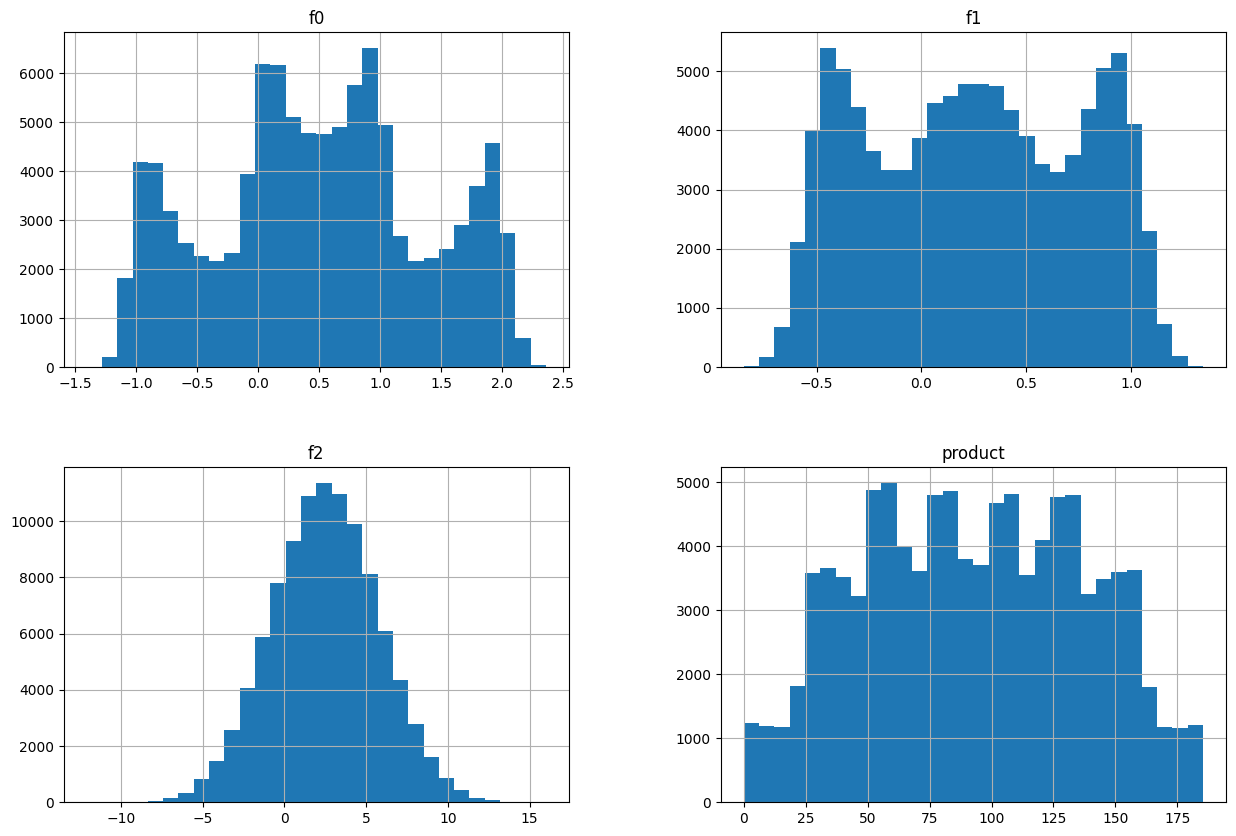

In [14]:
df0.hist(bins=30, figsize=(15, 10))
# plt.figure(figsize=(15, 10))

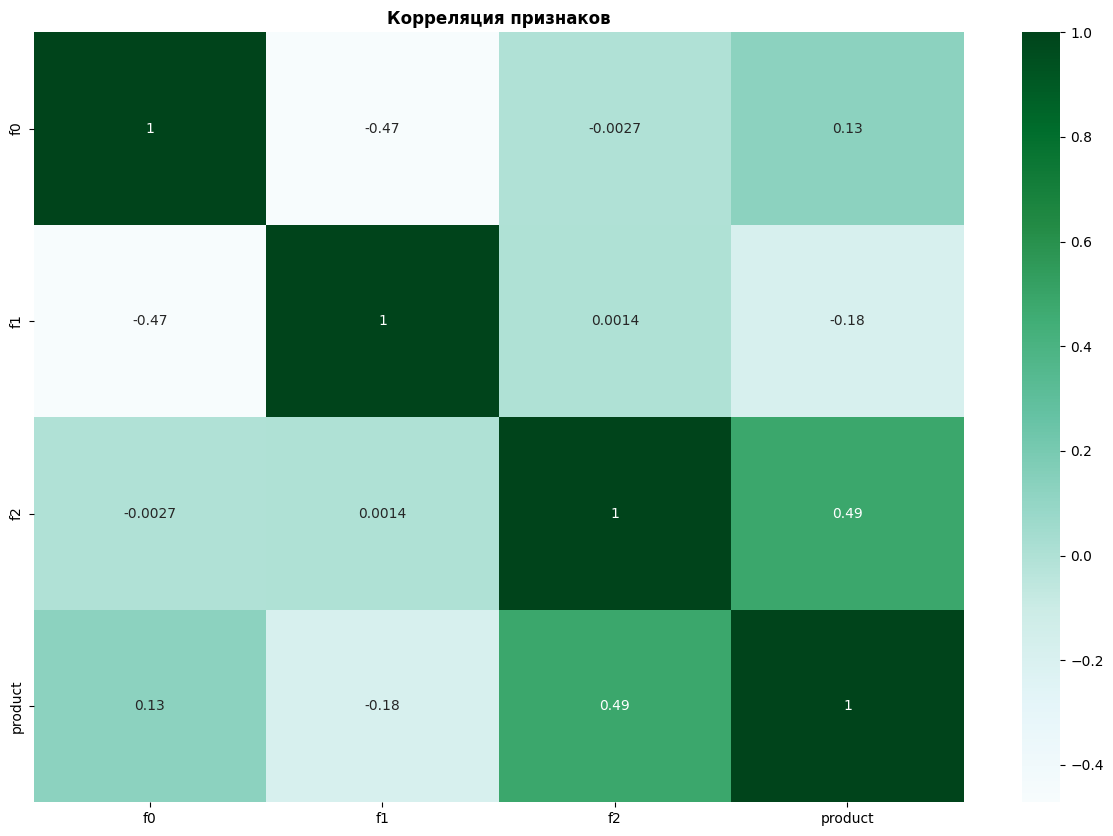

In [17]:
df0_without_id = df0.drop('id', axis=1)
plt.figure(figsize=(15, 10))
plt.title('Корреляция признаков', weight = 'bold')
sns.heatmap(df0_without_id.corr(method='spearman'), annot = True, cmap='BuGn')
plt.show()

In [18]:
print('Количество дубликатов в данных:', df0.duplicated().sum())
print(f'Количество столбцов: {df0.shape[1]}, число записей: {df0.shape[0]}')

Количество дубликатов в данных: 0
Количество столбцов: 5, число записей: 100000


- __Второй регион__

In [19]:
display(df1.info())
display(df1.describe())
display(df1.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


array([[<Axes: title={'center': 'f0'}>, <Axes: title={'center': 'f1'}>],
       [<Axes: title={'center': 'f2'}>,
        <Axes: title={'center': 'product'}>]], dtype=object)

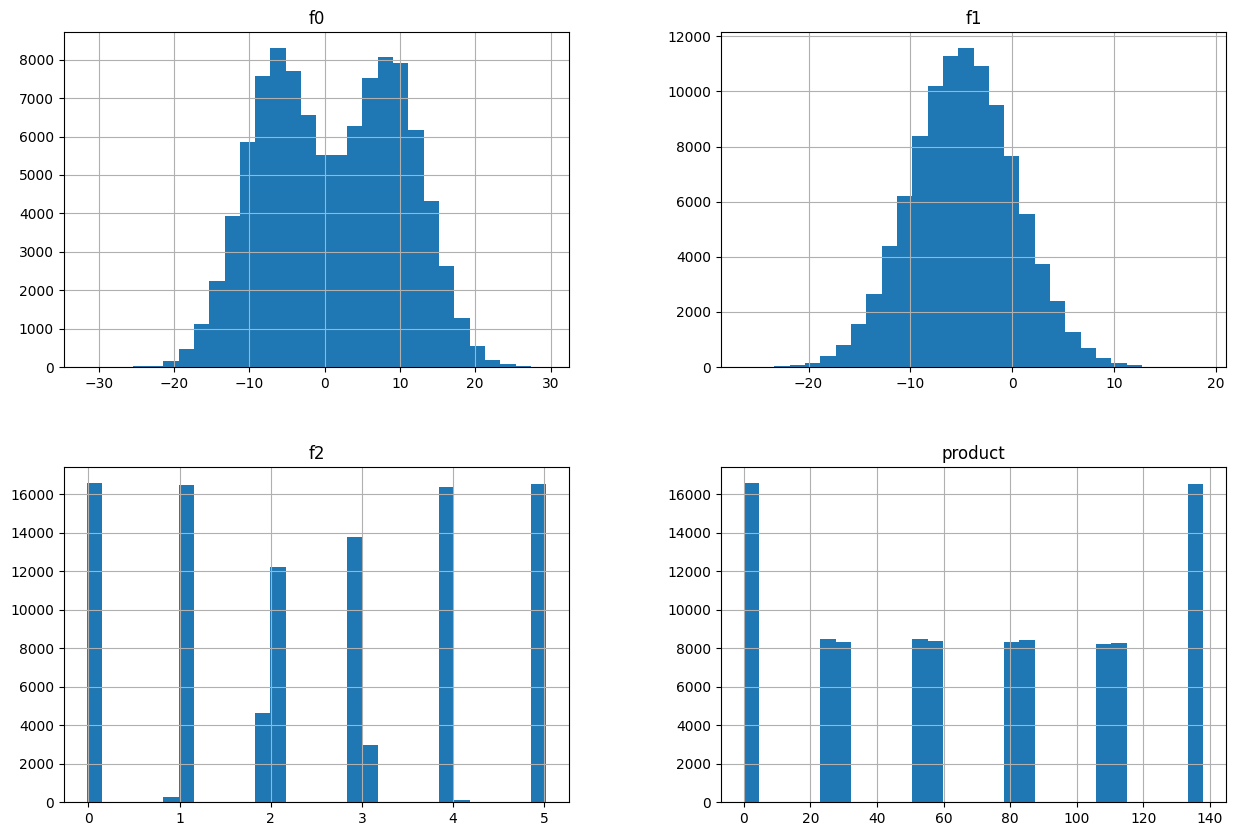

In [20]:
df1.hist(bins=30, figsize=(15, 10))

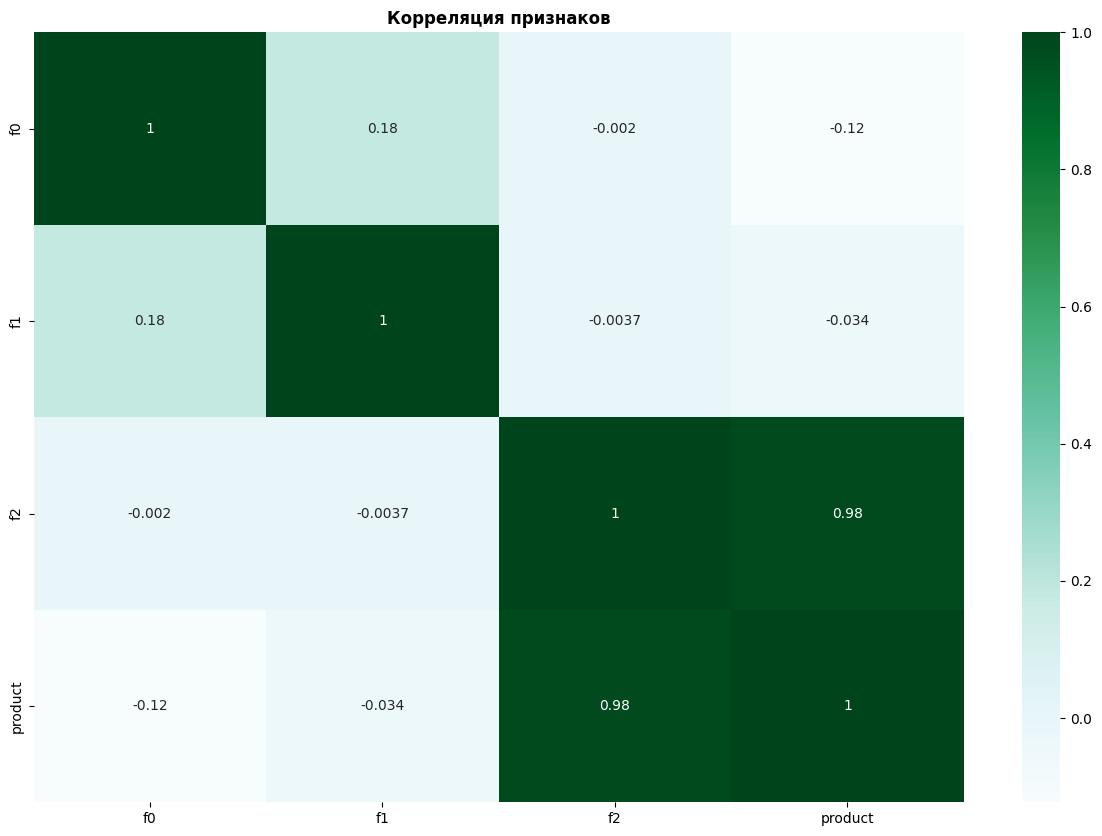

In [22]:
df1_without_id = df1.drop('id', axis=1)
plt.figure(figsize=(15, 10))
plt.title('Корреляция признаков', weight = 'bold')
sns.heatmap(df1_without_id.corr(method='spearman'), annot = True, cmap='BuGn')
plt.show()

In [23]:
print('Количество дубликатов в данных:', df1.duplicated().sum())
print(f'Количество столбцов: {df1.shape[1]}, число записей: {df1.shape[0]}')

Количество дубликатов в данных: 0
Количество столбцов: 5, число записей: 100000


- __Третий регион__

In [25]:
display(df2.info())
display(df2.describe())
display(df2.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


array([[<Axes: title={'center': 'f0'}>, <Axes: title={'center': 'f1'}>],
       [<Axes: title={'center': 'f2'}>,
        <Axes: title={'center': 'product'}>]], dtype=object)

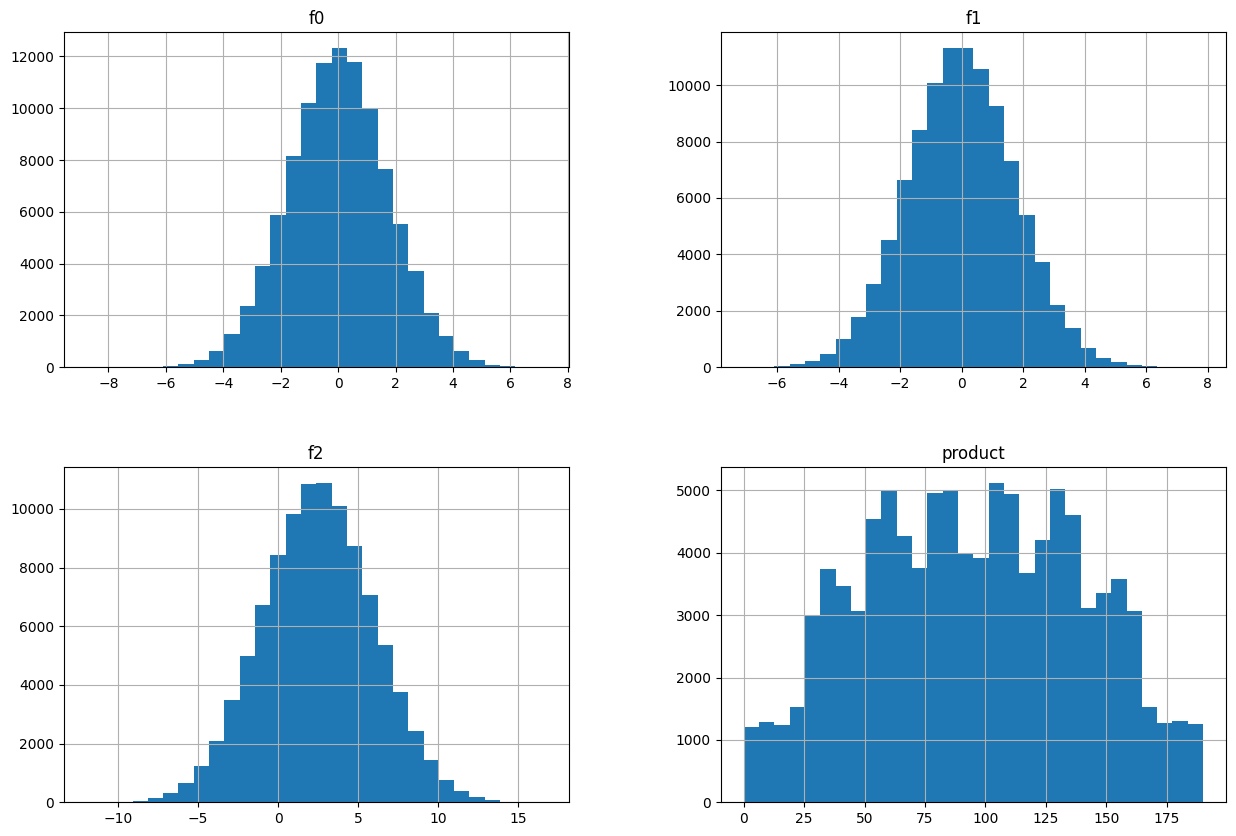

In [26]:
df2.hist(bins=30, figsize=(15, 10))

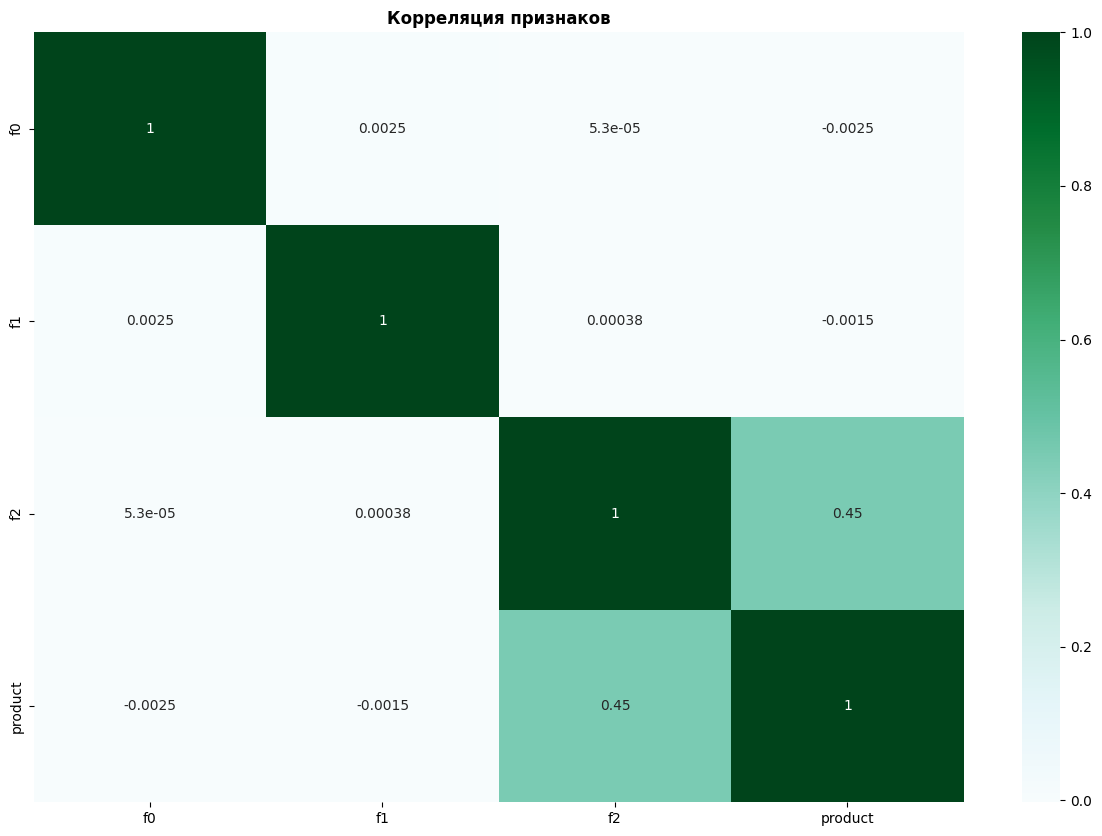

In [27]:
df2_without_id = df2.drop('id', axis=1)
plt.figure(figsize=(15, 10))
plt.title('Корреляция признаков', weight = 'bold')
sns.heatmap(df2_without_id.corr(method='spearman'), annot = True, cmap='BuGn')
plt.show()

In [30]:
print('Количество дубликатов в данных:', df2.duplicated().sum())
print(f'Количество столбцов: {df2.shape[1]}, число записей: {df2.shape[0]}')

Количество дубликатов в данных: 0
Количество столбцов: 5, число записей: 100000


В таблицах отсутствуют пропуски. Все данные, кроме колонки `id` имеют численное значение. Столбец `id` не несет информации для обучения модели. Для региона 1, признак `f2` имеет высокую корреляцию с целевым признаком.

## 4. Обучение и проверка модели

Удалим столбец `id` из данных по всем регионам.

In [32]:
df0.drop(['id'], axis='columns', inplace=True)
df1.drop(['id'], axis='columns', inplace=True)
df2.drop(['id'], axis='columns', inplace=True)

In [34]:
# выделим целевой признак
target_0 = df0['product']
target_1 = df1['product']
target_2 = df2['product']

# создадим признаки для модели
features_0 = df0.drop('product', axis=1)
features_1 = df1.drop('product', axis=1)
features_2 = df2.drop('product', axis=1)

# отделим обучающий (train) и проверочный (valid) датасеты
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(features_0, target_0, test_size=0.25, random_state=RANDOM_STATE)
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_1, target_1, test_size=0.25, random_state=RANDOM_STATE)
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_2, target_2, test_size=0.25, random_state=RANDOM_STATE)

# выведем сведения о разбивке данных
print(f'Данные разбиты в соотношении: '
      f'{len(features_train_0) / len(features_0):.2f}:'
      f'{len(features_valid_0) / len(features_0):.2f}')

Данные разбиты в соотношении: 0.75:0.25


In [36]:
model_0 = LinearRegression()
model_0.fit(features_train_0, target_train_0)
y_pred_0 = model_0.predict(features_valid_0)

In [37]:
# -----------------------------------------------------------------------------------------
# функция расчёта запасов нефти и RMSE по региону
# -----------------------------------------------------------------------------------------
def oil_reserves(features_train, target_train, features_valid, target_valid):
    model = LinearRegression().fit(features_train, target_train)
    predicted = model.predict(features_valid)
    rmse = (mean_squared_error(target_valid, predicted)) ** 0.5
    print(f'Средний запас предсказанного сырья в регионе: {predicted.mean():.2f} тыс. баррелей')
    print(f'RMSE модели {rmse:.2f}')
    return predicted

In [38]:
print('Регион 0')
predicted_0 = oil_reserves(features_train_0, target_train_0, features_valid_0, target_valid_0)
print()

print('Регион 1')
predicted_1 = oil_reserves(features_train_1, target_train_1, features_valid_1, target_valid_1)
print()

print('Регион 2')
predicted_2 = oil_reserves(features_train_2, target_train_2, features_valid_2, target_valid_2)

Регион 0
Средний запас предсказанного сырья в регионе: 92.49 тыс. баррелей
RMSE модели 37.66

Регион 1
Средний запас предсказанного сырья в регионе: 69.17 тыс. баррелей
RMSE модели 0.89

Регион 2
Средний запас предсказанного сырья в регионе: 95.15 тыс. баррелей
RMSE модели 40.05


Лучшее значение метрики *RMSE* показала модель для региона №1 - `0.89`.

## 5. Подготовка к расчёту прибыли

[к навигации](#Навигация)

Рассчитаем минимальный средний объём сырья в месторождениях региона, достаточный для его безубыточной разработки. По условиям у нас есть следующие данные:

- При разведке региона исследуют 500 точек;
- Выбирают 200 лучших точек для разработки;
- Бюджет на разработку скважин в регионе — 10 млрд. рублей;
- Доход с каждой единицы продукта составляет 450 тыс. рублей.
- Количество *bootstrap* выборок - 1000;
- Доверительный интервал 95%.

In [60]:
# сбросим индексы целевого признака в валидационной выборке для каждого региона:
target_valid_0.reset_index(drop=True, inplace=True)
target_valid_1.reset_index(drop=True, inplace=True)
target_valid_2.reset_index(drop=True, inplace=True)

# переведем предсказания в валидационной выборке в pd.Series:
predicted_0 = pd.Series(predicted_0)
predicted_1 = pd.Series(predicted_1)
predicted_2 = pd.Series(predicted_2)

# сохраним все ключевые значения для расчётов в отдельных глобальных переменных
POINTS = 500                                # количество точек исследования
TOP_POINTS = 200                            # количество лучших точек для разработки
BUDGET = 10000000000                        # бюджет на разработку
PROFIT = 450000                             # доход
BOOTSTRAP_SAMPLES = 1000                    # количество bootstrap выборок
ALPHA = 0.05                                # альфа-квантиль
STATE = np.random.RandomState(RANDOM_STATE)      # контейнер для генератора случайных чисел

zero_profit_value = BUDGET / (TOP_POINTS * PROFIT)
print (f'Достаточный объём сырья для безубыточной разработки новой скважины: {zero_profit_value:.2f} тыс. баррелей')

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11 тыс. баррелей


Данное значение превышает средние значения запасов скважин во всех регионах.

Напишем функцию для расчёта прибыли по набору отобранных месторождений и предсказаний модели, которая принимает на вход истинные значения целевого признака, предсказания и количество скважин, возвращает общую прибыль в миллионах рублей.

In [63]:
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
     # выбираем лучшие в количестве count штук
    selected = target[probs_sorted.index][:count]
     # считаем и возвращаем прибыль в миллионах рублей
    return (PROFIT * selected.sum() - BUDGET) / 1e6
    

## 6. Расчёт прибыли и рисков

Посчитаем риски и прибыль для каждого региона.

Применим технику *Bootstrap* для 1000 выборок, чтобы найти распределение прибыли.
Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

Создадим функцию для подсчета результатов.

In [61]:
# -----------------------------------------------------------------------------------------
# функция расчёта средней прибыли техникой bootstrap,
# доверительного интервала и риска убытков по региону
# -----------------------------------------------------------------------------------------
def distribution_revenue(target, probabilities):
    values = []
    for _ in range(BOOTSTRAP_SAMPLES):
        target_subsample = target.sample(n=POINTS, replace=True, random_state=STATE)
        probs_subsample = probabilities[target_subsample.index]
        values.append(revenue(target_subsample, probs_subsample, TOP_POINTS))

    values = pd.Series(values)
    print(f'Средняя прибыль: {values.mean():.2f} млн.руб')

    lower = values.quantile(ALPHA/2)
    upper = values.quantile(1 - (ALPHA/2))
    print(f'95%-й доверительный интервал: {lower:.2f} - {upper:.2f} млн.руб.')

    print(f'Риск получения убытков: {(values < 0).mean():.2%}')
    return

Выведем расчёты средней прибыли, доверительного интервала и риска убытков для каждого региона.

In [64]:
print('Регион 0')
distribution_revenue(target_valid_0, predicted_0)
print()
print('Регион 1')
distribution_revenue(target_valid_1, predicted_1)
print()
print('Регион 2')
distribution_revenue(target_valid_2, predicted_2)

Регион 0
Средняя прибыль: 449.19 млн.руб
95%-й доверительный интервал: -143.46 - 1014.05 млн.руб.
Риск получения убытков: 5.60%

Регион 1
Средняя прибыль: 526.46 млн.руб
95%-й доверительный интервал: 108.07 - 952.90 млн.руб.
Риск получения убытков: 0.90%

Регион 2
Средняя прибыль: 344.60 млн.руб
95%-й доверительный интервал: -219.84 - 899.90 млн.руб.
Риск получения убытков: 10.90%


## 7. Выводы


В регионе 0 и регионе 2 достаточно высокий средний показатель запаса предсказанного сырья. Однако, значение *RMSE* для данных регионов также высоко (**37.66** и **40.05** соответственно). Это свидетельствует о неоднозначности показателя, неточности модели регрессии.
В регионе 1 средний показатель запаса предсказанного сырья составляет **69** тыс. баррелей (ниже остальных регионов). Однако значение *RMSE* в данном регионе также небольшое **0.89**. Это говорит о точности предсказаний и качестве построенной модели для данного региона.
Средние показатели предсказанного сырья для одной скважины ниже теоретически необходимых *111.11* тыс. баррелей.

При применении техники *bootstrap*:
Оценка средней прибыли максимальна для региона 1: **526.46** млн. рублей.
Только регион 1 прогнозирует прибыльную разработку по 95% доверительному интервалу.
Риск убытков для региона 1: **0.9%**.

Для остальных регионов риск получить убыток значительно выше.

**Исходя из этих расчётов, только регион 1 можно рекомендовать для добычи нефти.**